The purpose of this notebook is tho show the full pipeline necessary to run your tensorflow model in tensorrt.

I will compare 3 different approaches:
 - run the raw tensorflow graph
 - rund a frozen version of the tensorflow graph
 - run a tensorrt engine created from the frozen tensorflow graph

In [1]:
import py3nvml
py3nvml.grab_gpus(num_gpus=1, gpu_fraction=0.9)

import cv2
import time
import sys
sys.path.append("../src")
import os
import glob

import numpy as np
import tensorflow as tf

import tensorrt as trt
from tensorrt.parsers import uffparser
import uff

from config import *
from train import _draw_box
from nets import *

import uff
import time
import pickle

import matplotlib.pyplot as plt

import py3nvml
py3nvml.grab_gpus(num_gpus=1, gpu_fraction=0.9)

import pycuda
import pycuda.autoinit

NUMFRAMES=100

/home/lscheucher/anaconda3/envs/tensorrt/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Package versions

In [2]:
print("tensorRT:",trt.__version__)
print("tensorflow:",tf.__version__)
print("UFF:",uff.__version__)
print("Pycuda:",pycuda.VERSION)

tensorRT: 4.0.1.6
tensorflow: 1.9.0
UFF: 0.3.0
Pycuda: (2018, 1)


In [3]:
mc = kitti_squeezeDetPlus_config()
mc.BATCH_SIZE = 1
mc.LOAD_PRETRAINED_MODEL = False
mc.TF_MODE = 'eval'
model = SqueezeDetPlus(mc,0)

INFO:tensorflow:Summary name mean iou is illegal; using mean_iou instead.


In [4]:
saver = tf.train.Saver(model.model_params)

In [5]:
sess_raw =  tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
saver.restore(sess_raw,'../data/model_checkpoints/squeezeDetPlus/model.ckpt-95000')

INFO:tensorflow:Restoring parameters from ../data/model_checkpoints/squeezeDetPlus/model.ckpt-95000


Reading the input image

In [6]:
f='../data/sample.png'
im = cv2.imread(f)
im = im.astype(np.float32, copy=False)
im = cv2.resize(im, (mc.IMAGE_WIDTH, mc.IMAGE_HEIGHT))
input_image = im - mc.BGR_MEANS
print(type(input_image))
print(input_image.shape)

<class 'numpy.ndarray'>
(375, 1242, 3)


# Run inference on the raw tensorflow graph
Here, we run some inference on the raw tensorflow graph, and track the time it needs.

Since we currently only, managed to get the feature extractor running in tensorrt, we also run just the feature extraction part of the graph here.

In [7]:
start = time.time()

for i in range(NUMFRAMES):
    # Detect
#     det_boxes, det_probs, det_class = sess.run(
#         fetches=[model.det_boxes, model.det_probs, model.det_class],
#         feed_dict={model.image_input:[input_image]})

    # Just the feature extraction subgraph
    result_raw =sess_raw.run(
        fetches=[model.preds],
        feed_dict={model.image_input:[input_image]});
#     # Filter
#     final_boxes, final_probs, final_class = model.filter_prediction(
#         det_boxes[0], det_probs[0], det_class[0])

#     keep_idx    = [idx for idx in range(len(final_probs)) \
#                       if final_probs[idx] > mc.PLOT_PROB_THRESH]
#     final_boxes = [final_boxes[idx] for idx in keep_idx]
#     final_probs = [final_probs[idx] for idx in keep_idx]
#     final_class = [final_class[idx] for idx in keep_idx]
end = time.time()
print("Elapsed time for",NUMFRAMES,"inference calls:",end-start," -> equals",NUMFRAMES/(end-start),'FPS')
print(result_raw[0].shape)

Elapsed time for 100 inference calls: 2.336027145385742  -> equals 42.80772173282569 FPS
(1, 22, 76, 72)


# Write the raw graph definition to file

In [8]:
LOGDIR='../tensorboard_graphs/raw'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess_raw.graph)

# freeze the graph

In [9]:
output_nodes = ['interpret_output/pred_class_probs','interpret_output/pred_confidence_score']
output_nodes = ['conv12/bias_add']
#output_nodes = ['interpret_output/strided_slice']


# We use a built-in TF helper to export variables to constants
frozen_graph = tf.graph_util.convert_variables_to_constants(
    sess=sess_raw, # The session is used to retrieve the weights
    input_graph_def=tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes
    output_node_names=output_nodes,#['sample_detection_results']#output_node_names.split(",") # The output node names are used to select the usefull nodes #TODO

)
frozen_graph = tf.graph_util.remove_training_nodes(frozen_graph)

with tf.gfile.GFile("./frozen_model.pb", "wb") as f:
    f.write(frozen_graph.SerializeToString())
    print("%d ops in the final graph." % len(frozen_graph.node))
    
sess_raw.close()

INFO:tensorflow:Froze 64 variables.
INFO:tensorflow:Converted 64 variables to const ops.
183 ops in the final graph.


# Write the frozen graph definition to file

In [10]:
LOGDIR='../tensorboard_graphs/frozen'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(frozen_graph)

In [11]:
type(frozen_graph)

tensorflow.core.framework.graph_pb2.GraphDef

# Run inference on the frozen tensorflow graph

In [12]:
with tf.Graph().as_default() as graph:
    tf.import_graph_def(frozen_graph, name="prefix")
    
    f='../data/sample.png'
    im = cv2.imread(f)
    im = im.astype(np.float32, copy=False)
    im = cv2.resize(im, (mc.IMAGE_WIDTH, mc.IMAGE_HEIGHT))
    input_image = im - mc.BGR_MEANS
    
    x = graph.get_tensor_by_name('prefix/image_input:0')
    y = graph.get_tensor_by_name('prefix/conv12/bias_add:0')
    
    with tf.Session(graph=graph) as sess_frozen:
        # Note: we don't nee to initialize/restore anything
        # There is no Variables in this graph, only hardcoded constants
        start = time.time()
        for i in range(NUMFRAMES):
            result_frozen = sess_frozen.run(y, feed_dict={x:[input_image] } )
        end = time.time()
        
print("Elapsed time for",NUMFRAMES,"inference calls:",end-start," -> equals",NUMFRAMES/(end-start),'FPS')
print("output shape:",result_frozen.shape)
print("difference from raw result:",np.linalg.norm(result_frozen-result_raw))

Elapsed time for 100 inference calls: 1.7476301193237305  -> equals 57.2203459383593 FPS
output shape: (1, 22, 76, 72)
difference from raw result: 0.0


# Using tensorRT for inference

## Creat uff-model

In [13]:
uff_model = uff.from_tensorflow(frozen_graph, output_nodes, output_filename = "model.uff")

Using output node conv12/bias_add
Converting to UFF graph
No. nodes: 174
UFF Output written to model.uff


In [14]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)

for the paerser, we have to register input and output names.

In [15]:
# BATCH_SIZE = 20
# IMAGE_HEIGHT = 375
# IMAGE_WIDTH = 1242
# IMAGE_CHANNELS = 3

IMAGE_INPUT_SHAPE = (3,mc.IMAGE_HEIGHT,mc.IMAGE_WIDTH)
BOX_SHAPE =  (mc.ANCHORS,1)
DELTA_SHAPE = (mc.ANCHORS,4)
BOX_INPUT_SHAPE =  (mc.ANCHORS,4)

parser = uffparser.create_uff_parser()
parser.register_input("image_input", IMAGE_INPUT_SHAPE, 0)
# parser.register_output('interpret_output/pred_class_prob')
# parser.register_output('interpret_output/pred_confidence_score')
parser.register_output('conv12/relu')

True

**NOTE** that the input image shape has cahnged compared to the tensorflow graph. Now, the channels come first. I don't know why that is, but otherwise the engine creation will fail.

## Creating a tensorRT engine

**NOTE** that the input shape here is different than the shape dureing model tarining. I'm not sure why that is, but if you do it any different, you wil get an error

In [16]:
def create_engine(trt, g_logger, uff_model, uff_parser_instance):
    engine = None
    try:
        engine = trt.utils.uff_to_trt_engine(g_logger, uff_model, uff_parser_instance, 1, 1 << 20)
    except:
        print("engine Failed")
    return engine


input_names_list= ["image_input"]
input_shapes_list= [(3,mc.IMAGE_HEIGHT,mc.IMAGE_WIDTH)]
output_names = ['conv12/bias_add']
#output_names = ['interpret_output/strided_slice']


g_logger = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)
uff_parser_instance = uffparser.create_uff_parser()

if len(input_names_list) == len(input_shapes_list):
    for i in range(0, len(input_names_list)):
        uff_parser_instance.register_input(input_names_list[i], input_shapes_list[i], 0)

for i in range(0, len(output_names)):
    uff_parser_instance.register_output(output_names[i])

engine = create_engine(trt, g_logger, uff_model, uff_parser_instance)
result = True if engine is not None else False
print(result)

True


In [17]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
context = engine.create_execution_context()

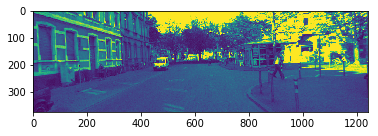

In [18]:
# import cv2
# img = cv2.imread("../data/sample.png")
# img = img.astype(np.float32)/256
# print(img.shape)
# #plt.imshow(img)
input_image_reshaped = np.moveaxis(input_image, [0, 1, 2], [1,2,0])#TODO possible point of failure
input_image_reshaped = np.ascontiguousarray(input_image_reshaped).astype(np.float32)
plt.imshow(input_image[:,:,0]) #just checking that the data-moving has been done correctly

**NOTE** Don't forget to convert your inputs to the correct number-format, in this case float32.
Otherwise cuda will still run te graph, but by reinterpreting your input as a different format, ypu will effectively feed garbage to the network.

Next, we allocate memory on the GPU, as well as on the host to hold results after inference. The size of these allocations is the size of the input/expected output * the batch size.

In [19]:
import pycuda.driver as cuda
result_tensorrt = np.empty((1,22,76,72), dtype = np.float32) #TODO possible point of failure
#result_tensorrt = np.empty(22*76*72, dtype = np.float32) #TODO possible point of failure
d_input = cuda.mem_alloc(1 * input_image_reshaped.nbytes)
d_output = cuda.mem_alloc(1 * result_tensorrt.nbytes)

The engine requires bindings (pointers to GPU memory). PyCUDA lets us do this by casting the results of memory allocations to ints.

In [20]:
bindings = [int(d_input), int(d_output)]

In [21]:
stream = cuda.Stream()

Now, we transfer the data to the GPU, run inference, then transfer the results to the host.

In [22]:
start = time.time()
for i in range(NUMFRAMES):
    # Transfer input data to device
    cuda.memcpy_htod_async(d_input, input_image_reshaped, stream)
    #cuda.memcpy_htod_async(d_input, input_image, stream)
    # Execute model
    context.enqueue(1, bindings, stream.handle, None)
    # Transfer predictions back
    cuda.memcpy_dtoh_async(result_tensorrt, d_output, stream)
end = time.time()
# Syncronize threads
stream.synchronize()

print("Elapsed time for",NUMFRAMES,"inference calls:",end-start," -> equals",NUMFRAMES/(end-start),'FPS')
print("output shape:",result_tensorrt.shape)
print("difference from raw result:",np.linalg.norm(result_tensorrt-result_raw))

Elapsed time for 100 inference calls: 0.5537629127502441  -> equals 180.58269648892428 FPS
output shape: (1, 22, 76, 72)
difference from raw result: 0.0


**SUCCESS** All 3 versions come to the same result, but the tensorRT one is significantly faster.